In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import importance_sample_lib as imp_lib
import galaxy_experiments_lib as galaxy_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
max_detections = 3

In [4]:
galaxy_data = Synthetic(side_len, min_galaxies=0, max_galaxies=3, mean_galaxies=2, num_bands=5,
                        num_images=100, brightness = 5000)

In [5]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [6]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']
num_galaxies_batch1 = train_data_batch1['num_galaxies']

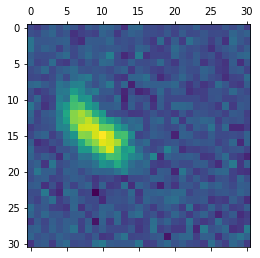

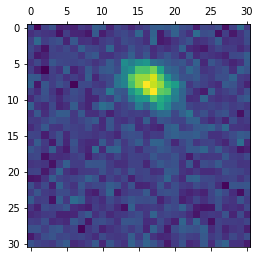

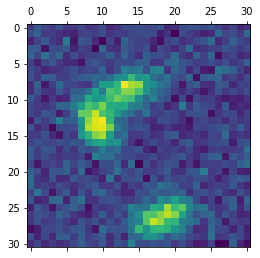

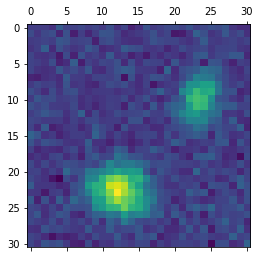

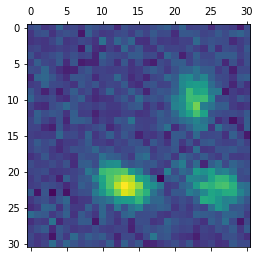

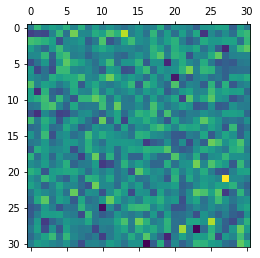

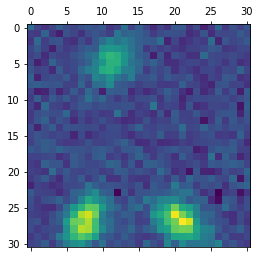

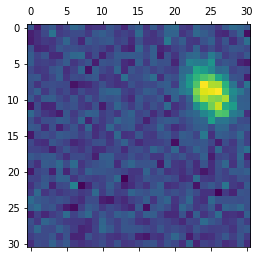

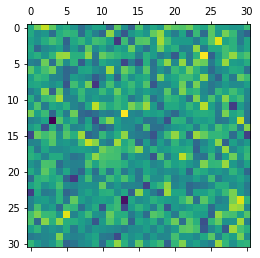

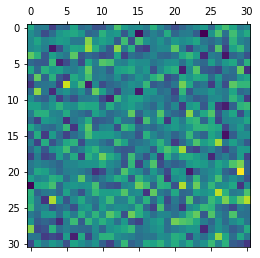

In [7]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

# Load the VAE

In [8]:
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [9]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [10]:
state_dict = torch.load('../galaxy_results/multiple_detections/' + 
                        'galaxy_vae_3detections_bs_on_imp_sample_off_randstars_epoch200.dat',
                        map_location='cpu')
galaxy_rnn.load_state_dict(state_dict, strict = True)

In [11]:
galaxy_rnn.eval(); 
galaxy_rnn.one_galaxy_vae.eval(); 

## Check losses

In [12]:
_, loss, _, = imp_lib.get_importance_sampled_galaxy_loss(galaxy_rnn, images_batch1, backgrounds_batch1,
                                            use_importance_sample = False,
                                            use_baseline = False,
                                            max_detections = max_detections)

print(loss)

tensor(23774.8887)


In [13]:
_, loss, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_rnn, images_batch1, backgrounds_batch1,
                                            use_importance_sample = False,
                                            use_baseline = False,
                                            max_detections = max_detections)

print(loss)

tensor(23860.7773)


In [14]:
_, recon_means, _, _, recon_mean_history, was_on_history = \
    imp_lib.forward_multiple_detections(galaxy_rnn, images_batch1, backgrounds_batch1,
                                    use_importance_sample = False,
                                    max_detections = max_detections, 
                                    return_history = True)

# Check reconstructions

In [15]:
num_detections = was_on_history.sum(1)

In [16]:
backgrounds_batch1[0].shape

torch.Size([5, 31, 31])

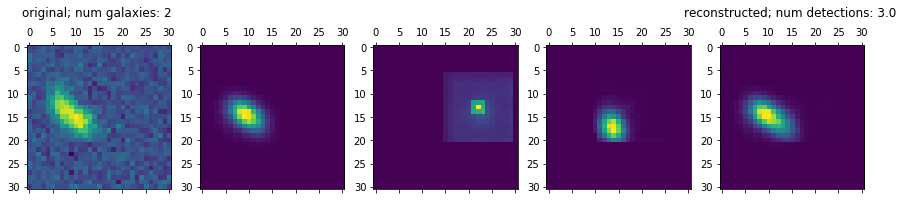

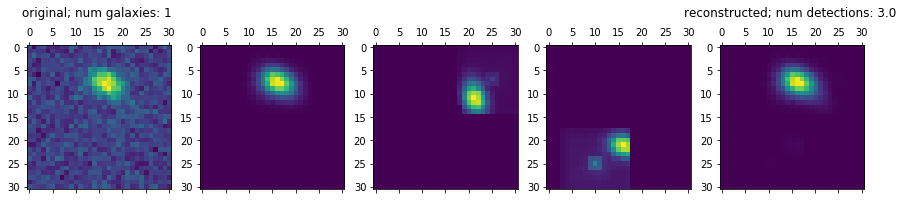

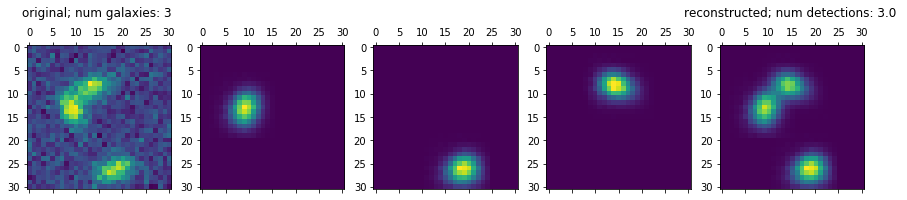

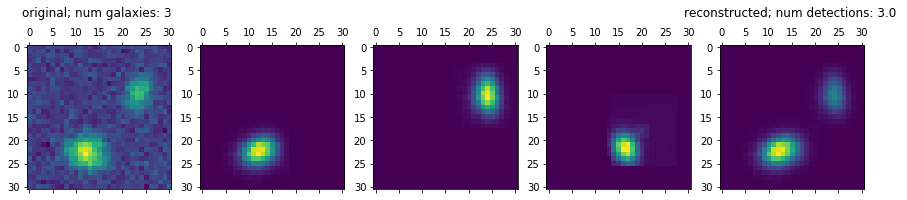

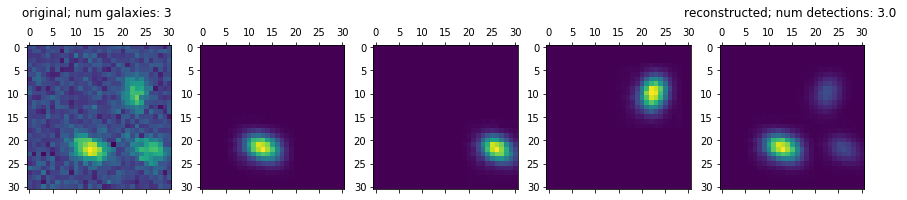

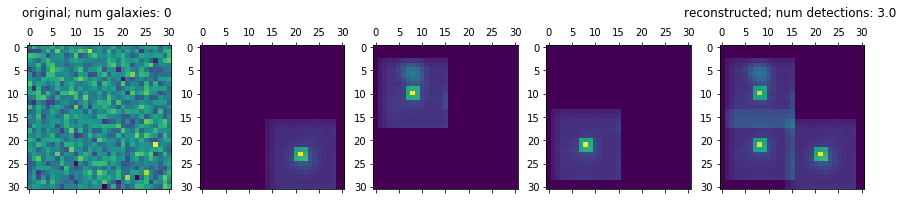

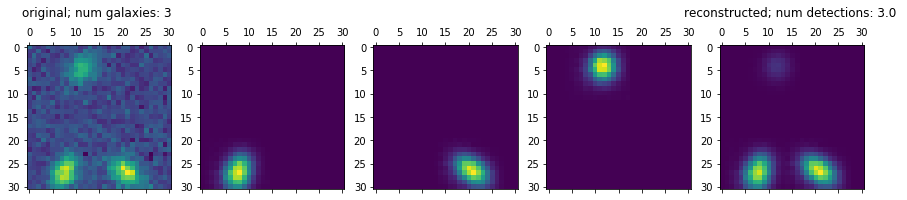

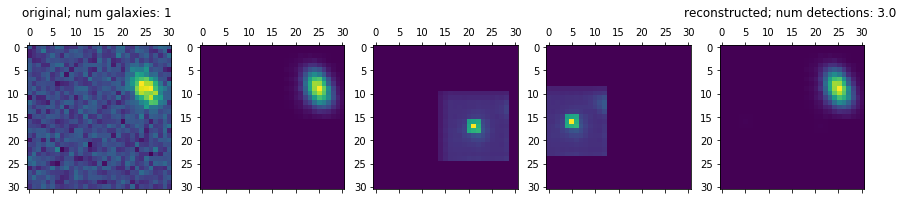

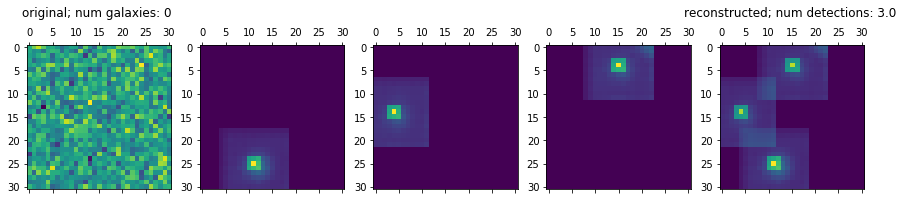

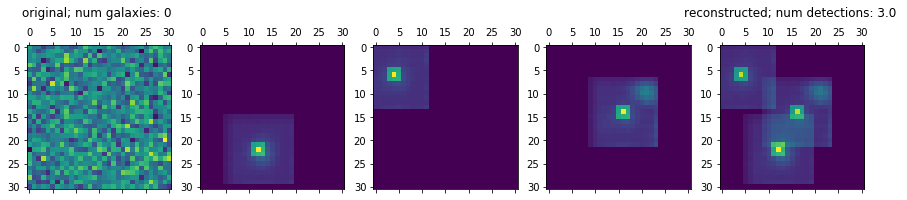

In [17]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 5, figsize=(15, 15))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[0].set_title('original; num galaxies: {} \n'.format(num_galaxies_batch1[n]))
    
    for i in range(max_detections): 
        axarr[i + 1].matshow(recon_mean_history.detach()[n, 0, :, :, i].squeeze())
    
    axarr[4].matshow(recon_means.detach()[n, 0, :, :].squeeze())
    axarr[4].set_title('reconstructed; num detections: {} \n'.format(num_detections[n]))
    

In [18]:
all_off = torch.LongTensor([530] * 10)

In [19]:
recon_mean = galaxy_rnn.sample_conditional_a(images_batch1 - backgrounds_batch1, backgrounds_batch1, all_off)[0]

In [20]:
torch.max(torch.abs(recon_mean))

tensor(0.)

# Optimization path

In [24]:
# loss_array_imp_sample = np.load('../galaxy_results/multiple_detections/' + 
#                                 'galaxy_vae_3detections_batch_losses_array.npy')
loss_array_default = np.load('../galaxy_results/multiple_detections/galaxy_vae_3detections_bs_on_imp_sample_off_randstars_batch_losses_array.npy')

In [25]:
fontsize = 18

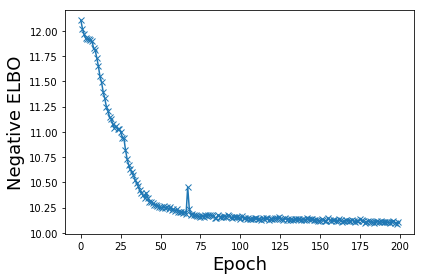

In [26]:
# plt.plot(np.minimum(loss_array_imp_sample, 1e6), '-x')
plt.plot(np.log(loss_array_default), '-x')

plt.xlabel('Epoch', fontsize = fontsize)
plt.ylabel('Negative ELBO', fontsize = fontsize)
# plt.legend(('REINFORCE + CV', 'Rao-Blackwellized'))
plt.tight_layout()